Построить модель градиентного бустинга для показателя частоты страховых убытков. Можно предобработать исходные данные, добавив дополнительные фичи. Также можно использовать различные методы для подбора гиперпараметров. Оценить результаты построенного классификатора, выявить возможные проблемы. Сравнить результаты с полученным ранее результатом с использованием Пуассоновской регрессии. Проанализировать результаты, предложить способы решения обнаруженных проблем и/или попробовать его улучшить. При желании можно использовать любой другой пакет для построения моделей градиентого бустинга.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from insolver import InsDataFrame, InsolverGradientBoostingWrapper, train_val_test_split

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Exposure           115155 non-null  float64
 1   LicAge             115155 non-null  int64  
 2   RecordBeg          115155 non-null  object 
 3   RecordEnd          59455 non-null   object 
 4   Gender             115155 non-null  object 
 5   MariStat           115155 non-null  object 
 6   SocioCateg         115155 non-null  object 
 7   VehUsage           115155 non-null  object 
 8   DrivAge            115155 non-null  int64  
 9   HasKmLimit         115155 non-null  int64  
 10  BonusMalus         115155 non-null  int64  
 11  ClaimAmount        115155 non-null  float64
 12  ClaimInd           115155 non-null  int64  
 13  ClaimNbResp        115155 non-null  float64
 14  ClaimNbNonResp     115155 non-null  float64
 15  ClaimNbParking     115155 non-null  float64
 16  Cl

### Предобработка данных

In [4]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [5]:
class InsDataFrame_Fr(InsDataFrame):

    # Experience (weeks to years)
    @staticmethod
    def _exp(exp, exp_max):
        if pd.isnull(exp):
            exp = None
        elif exp < 0:
            exp = None
        else:
            exp * 7 // 365
        if exp > exp_max:
            exp = exp_max
        return exp

    # Marital status
    _MariStat_dict = {'Other':0, 'Alone':1}

    def transform_MariStat(self):
        self._df['MariStat'] = self._df['MariStat'].map(self._MariStat_dict)
    
    # Social category
    def transform_SocioCateg(self):
        self._df['SocioCateg'] = self._df['SocioCateg'].str.slice(0,4)

In [6]:
data = InsDataFrame_Fr()

In [7]:
data.load_pd(df)

In [8]:
data.columns_match({'DrivAge':'driver_minage','LicAge':'driver_minexp'})

In [9]:
data.transform_age()
data.transform_exp()
data.transform_gender()
data.transform_MariStat()
data.transform_SocioCateg()

data.transform_age_gender()
data.polynomizer('driver_minage_m')
data.polynomizer('driver_minage_f')

data.get_dummies(['VehUsage', 'SocioCateg'])

col_features = [
    'driver_minexp',
    'Gender',
    'MariStat',
    'HasKmLimit',
    'BonusMalus',
    'OutUseNb',
    'RiskArea',
    'driver_minage_m',
    'driver_minage_f',
    'driver_minage_m_2',
    'driver_minage_f_2',
    'VehUsage_Private',
    'VehUsage_Private+trip to office',
    'VehUsage_Professional',
    'VehUsage_Professional run',
    'SocioCateg_CSP1',
    'SocioCateg_CSP2',
    'SocioCateg_CSP3',
    'SocioCateg_CSP4',
    'SocioCateg_CSP5',
    'SocioCateg_CSP6',
    'SocioCateg_CSP7'
    
]

col_target = ['ClaimAmount', 'ClaimsCount']
df_freq = data.get_pd(col_features+col_target)

In [10]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 24 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   driver_minexp                    115155 non-null  int64  
 1   Gender                           115155 non-null  int64  
 2   MariStat                         115155 non-null  int64  
 3   HasKmLimit                       115155 non-null  int64  
 4   BonusMalus                       115155 non-null  int64  
 5   OutUseNb                         115155 non-null  float64
 6   RiskArea                         115155 non-null  float64
 7   driver_minage_m                  115155 non-null  int64  
 8   driver_minage_f                  115155 non-null  int64  
 9   driver_minage_m_2                115155 non-null  int64  
 10  driver_minage_f_2                115155 non-null  int64  
 11  VehUsage_Private                 115155 non-null  uint8  
 12  Ve

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Заменим значение 11 на 10.

In [11]:
df_freq['ClaimsCount'] = df_freq['ClaimsCount'].replace({11:10}).fillna(0)

Посмотрим, сколько полисов соответствуют каждому из значений ClaimsCount, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [12]:
FreqCount = pd.DataFrame(df_freq.groupby('ClaimsCount').size(), columns=['Count'])

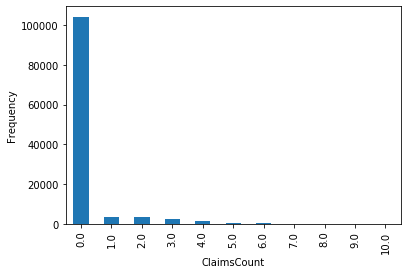

In [13]:
FreqCount.Count.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [14]:
FreqCount

,Count
ClaimsCount,
0.0,104286
1.0,3339
2.0,3529
3.0,2310
4.0,1101
5.0,428
6.0,127
7.0,26
8.0,6


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец weight. Присвоим ему некоторые значения, например, можно задать 0.05 для значений ClaimsCount 0, а для остальных - 1 (Для этого можем использовать функцию np.where). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [15]:
df_freq['weight'] = np.where(df_freq.ClaimsCount == 0, 0.02, 1)

In [16]:
df_freq.head() 

,driver_minexp,Gender,MariStat,HasKmLimit,BonusMalus,OutUseNb,RiskArea,driver_minage_m,driver_minage_f,driver_minage_m_2,...,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,ClaimAmount,ClaimsCount,weight
0,52,0,0,0,50,0.0,9.0,46,18,2116,...,0,0,0,0,1,0,0,0.0,0.0,0.02
1,52,0,0,0,50,0.0,9.0,46,18,2116,...,0,0,0,0,1,0,0,0.0,0.0,0.02
2,52,0,0,0,68,0.0,7.0,32,18,1024,...,0,0,0,0,1,0,0,0.0,0.0,0.02
3,52,1,0,0,50,0.0,8.0,18,52,324,...,0,0,0,0,1,0,0,0.0,0.0,0.02
4,52,0,0,0,50,0.0,7.0,57,18,3249,...,0,0,0,0,0,1,0,0.0,0.0,0.02


Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [17]:
x_train, x_valid, x_test, \
y_train, y_valid, y_test = train_val_test_split(df_freq.drop(['ClaimAmount', 'ClaimsCount'], axis=1),
                                                df_freq.ClaimsCount, val_size=0.15, test_size=0.15, random_state=42)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [18]:
igb = InsolverGradientBoostingWrapper(algorithm='xgboost')

Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [19]:
# Определим границы, в которых будем искать гиперпараметры 

space_xgboost = {
              'objective': 'multi:softmax',
              'num_class': len(df_freq.ClaimsCount.unique()),
              'num_boost_round': hp.choice('num_boost_round', [50, 300, 500]),
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
                               'gamma':hp.uniform('gamma', 0.01, 1000),
    'tree_method':'hist'
              }

In [20]:
cv_par = {'num_boost_round' : 1000,
         'nfold': 3,
          'early_stopping_rounds':20,
          'seed' :0,
          'shuffle':True,
          'stratified':False
         }

In [21]:
igb.hyperopt_cv(x_train.drop('weight', axis=1),y_train, space_xgboost,cv_par,
               data_params={'weight': x_train['weight']},max_evals=50)

100%|██████████| 50/50 [07:22<00:00,  8.86s/trial, best loss: 0.710049]          


In [22]:
igb.fit_booster(x_train.drop('weight', axis=1),y_train, core_params={'evals': [((x_train.drop('weight', axis=1),y_train),'train'),
                                                                              ((x_valid.drop('weight', axis=1), y_valid),'valid')]})

[0]	train-merror:0.966926	valid-merror:0.964397
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 20 rounds.
[1]	train-merror:0.96602	valid-merror:0.962892
[2]	train-merror:0.96504	valid-merror:0.964687
[3]	train-merror:0.965983	valid-merror:0.96515
[4]	train-merror:0.965946	valid-merror:0.965208
[5]	train-merror:0.965871	valid-merror:0.965034
[6]	train-merror:0.965847	valid-merror:0.964803
[7]	train-merror:0.965648	valid-merror:0.965092
[8]	train-merror:0.965723	valid-merror:0.965034
[9]	train-merror:0.965983	valid-merror:0.964918
[10]	train-merror:0.965921	valid-merror:0.964513
[11]	train-merror:0.965499	valid-merror:0.964513
[12]	train-merror:0.965474	valid-merror:0.964803
[13]	train-merror:0.965611	valid-merror:0.964745
[14]	train-merror:0.965623	valid-merror:0.964745
[15]	train-merror:0.965599	valid-merror:0.964687
[16]	train-merror:0.965549	valid-merror:0.964629
[17]	train-merror:0.965536	vali

Далее обучим нашу модель с оптимальными параметрами

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.

In [23]:
dfsets = [{'set': 'train', 'x': x_train.drop('weight', axis=1), 'target': y_train},
          {'set': 'valid', 'x': x_valid.drop('weight', axis=1),  'target': y_valid},
          {'set': 'test', 'x': x_test.drop('weight', axis=1),  'target': y_test}]

In [24]:
for dfset in dfsets:
    class_preds = igb.booster.predict(xgb.DMatrix(dfset['x'])) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set']) +':', f1_score(dfset['target'], class_preds, average='micro'))# Посчитаем F1 Score

F1 Score on train: 0.034562755095711294
F1 Score on valid: 0.035255296978117405
F1 Score on test: 0.031492416348269076


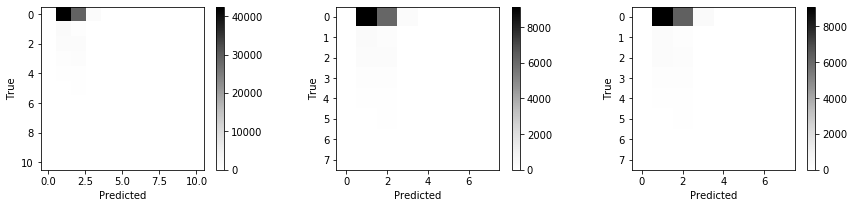

In [25]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], igb.booster.predict(xgb.DMatrix(dfsets[i]['x'])))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

 f1 дмаленькая
 
 
 чтобы улучшить результат модели нужно еще поработать над feature engineering 